# Sprint　機械学習スクラッチ　SVM  
＜目的＞  
スクラッチを通してSVMを理解する
線形モデルと異なる手法に触れる

分類のためのサポートベクターマシン（SVM、サポートベクトルマシン）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。  
SVMには学習時に分類の間違いを認めるソフトマージンSVMと、認めないハードマージンSVMがありますが、ここでは実装が単純なハードマージンSVMを扱います。

### 【問題1】ラグランジュの未定乗数法による最急降下  
SVMの学習は、ラグランジュの未定乗数法を用います。サンプル数分のラグランジュ乗数 $\lambda$ を用意して、以下の式により更新していきます。この計算を行うメソッドをScratchSVMClassifierクラスに実装してください。

$$
\lambda_i^{new}=\lambda_i+\alpha(1-\sum_{j=1}^{n}\lambda_jy_iy_jk(\boldsymbol{x_i},\boldsymbol{x_j}))
$$

ここで $k(\boldsymbol{x_i}, \boldsymbol{x_j})$ はカーネル関数です。線形カーネルの場合は次のようになります。他のカーネル関数にも対応できるように、この部分は独立したメソッドとしておきましょう。

$$
k(\boldsymbol{x_i},\boldsymbol{x_j})=\boldsymbol{x_i}^T\boldsymbol{x_j}
$$

条件として、更新毎に $\lambda_i >= 0$を満たす必要があります。満たさない場合は $\lambda_i = 0$とします。

$i, j$ : サンプルのインデックス  
$\lambda_i^{new}$ : 更新後のi番目のサンプルのラグランジュ乗数  
$\lambda_i$ : 更新前のi番目のサンプルのラグランジュ乗数  
$\alpha$ : 学習率  
$\lambda_j$ : j番目のサンプルのラグランジュ乗数  
$y_i$ : i番目のサンプルのラベル  
$y_j$ : j番目のサンプルのラベル  
$\boldsymbol{x_i}$ : i番目のサンプルの特徴量ベクトル  
$\boldsymbol{x_j}$ : j番目のサンプルの特徴量ベクトル  

あるサンプルに対しての全てのサンプルとの関係を計算していくことになります。

### 【問題2】サポートベクターの決定  
計算したラグランジュ乗数 $\lambda$ が設定した閾値より大きいサンプルをサポートベクターとして扱います。推定時にサポートベクターが必要になります。サポートベクターを決定し、インスタンス変数として保持しておくコードを書いてください。  
閾値はハイパーパラメータですが、1e-5程度からはじめると良いでしょう。サポートベクターの数を出力させられるようにしておくと学習がうまく行えているかを確認できます。

### 【問題3】推定  
推定時には、推定したいデータの特徴量とサポートベクターの特徴量をカーネル関数によって計算します。求めた $f(\boldsymbol{x})$ の符号が分類結果です。

$$
f(\boldsymbol{x})=\sum_{n=1}^{N}\lambda_ny_{sv_n}k(\boldsymbol{x}, \boldsymbol{s_n})
$$

$\boldsymbol{x}$ : 推定したいデータの特徴量ベクトル  
$N$ : サポートベクターの数  
$n$ : サポートベクターのインデックス  
$\lambda_n$ : $n$番目のサポートベクターのラグランジュ乗数  
$y_{sv_n}$ : $n$番目のサポートベクターのラベル  
$k()$ : カーネル関数  
$\boldsymbol{s_n}$ : $n$番目のサポートベクターの特徴量  

### ＜SVMとはどのような仕組みか＞  
スクラッチ実装に必要な情報は以上ですが、大まかな仕組みの解説を行います。  
SVMは決定境界と近くの点の距離（マージン）を最大化する方法です。特徴量が2つであれば以下の図のように線を引くことを考えます。

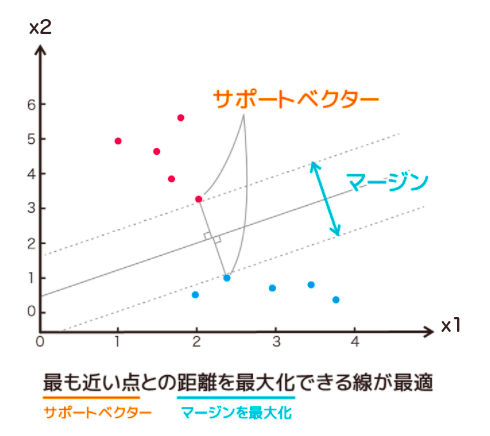

In [3]:
Image("6-1.png")

決定境界は線形であれば、線形回帰やロジスティック回帰と同様に次の式です。

$$
y(x)=w^Tx
$$

$x$ : 特徴量ベクトル  
$w$ : 重みベクトル  

決定境界とある点 $x$ との距離 $r$ は以下の式で求められます。高校数学で学ぶ「点と直線の距離の公式」や「点と平面の距離の公式」を一般化したものです。

$$
r=\frac{y_iy(x)}{\|w\|}=\frac{y_iw^Tx}{\|w\|}
$$


$||w||$ はベクトル $w$ の大きさで、特徴量が2つならば $||w|| = \sqrt{w_{1}^2+w_{2}^2}$ です。また、学習するi番目のデータのラベルを $y_{i}=-1$または$y_{i}=1$ としています。  
訓練データの中で「最も距離 $r$ が短くなる点x（サポートベクター）の距離 $r$ を最大化する $w$ を求める」ことがSVMによる分類だと言い換えられます。  
これは非常に複雑な問題です。 $w$ を変化させると、最も距離 $r$ が短くなる点x（サポートベクター）も変化していくからです。計算するためには、問題を扱いやすい形に変形させる必要があります。

### ＜扱いやすい形にする  ＞

まず定数 $M(>0)$ を置くと、先ほどの問題は、

「$\frac{M}{||w||}$ を $y_{i}(w^{T}x_{i})\geq M$ という条件の元で最大化する $w$ や $M$ を求める問題」  

と表現できます。条件式は $x_{i}$ に訓練データの全ての点を入れて成り立つ必要があります。まだまだややこしいですが、これをMで割ってしまいます。そうすると、  

「$\frac{1}{||w||}$ を $y_{i}(\frac{w^{T}}{M}x_{i})\geq 1$ という条件の元で最大化する $w$ や $M$ を求める問題」  

になり、さらに $w^{T} \gets \frac{w^{T}}{M}$ と置き換えてしまいます。  
そうすれば、  

「 $\frac{1}{||w||}$ を $y_{i}(w^{T}X_{i})\geq 1$ という条件の元で最大化する $w$を求める問題」  

まで簡単化できます。 $\frac{1}{||w||}$ を最大化するというのは $||w||$ を最小化することと同じです。これを後々さらに扱いやすくするために $\frac{1}{2}||w||^2$ を最小化すると考えます。よって、  

「 $\frac{1}{2}||w||^2$ を $y_{i}(w^{T}x_{i})\geq 1$ という条件の元で最小化する $w$ を求める問題」  

とすることができます。  


 
### ＜解きやすい問題にする（双対化）＞  

こういった不等式制約を持つ最適化問題は次のように ラグランジュの未定乗数法 で置き換えられることが知られています。  
なお、このように難しい問題を別の簡単な問題に言い換えることを 双対化する といいます。  
ラグランジュの未定乗数法を用いると以下のラグランジュ関数が得られます。

$$
L(w,\lambda)=\frac{1}{2}\|w\|^2-\sum_{i-1}^{N}\lambda_i\{y_i(w^Tx_i)-1\}
$$

$\lambda$ はラグランジュ乗数と呼ばれる数で、0以上の値です。これを $w$について微分し、0に等しいと置くと、次の式が得られます。

$$
w=\sum_{i-1}^{N}\lambda_iy_ix_i
$$

（この微分のために $||w||$ ではなく $\frac{1}{2}||w||^2$ としています）  
これをラグランジュ関数に代入して整理すると

$$
\sum_{i=1}^{N}\lambda_i-\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}\lambda_i\lambda_jy_iy_jx_i^Tx_j
$$

を $\lambda_{i} \geq 0$ かつ $\sum_{n=1}^{N}\lambda_{i}y_{i} = 0$ の条件の元で最大化するときの $\lambda_{i}$ を探す問題に双対化できます。  
この形になれば、$\lambda$ を勾配降下法により求めることができます。$w$は出てきませんが、得られる結果は同じです。

In [4]:
import numpy as np
import random
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
%matplotlib inline
from sklearn.svm import SVC
from sklearn import metrics
from IPython.display import Image
from sklearn.datasets import make_moons

In [5]:
class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。
    　・線形カーネル（linear）
    　・多項式カーネル（poly）
    　・ガウスカーネル（rbf）
    d : int
      多項式カーネルの次元
    gamma : float
      多項式/ガウス カーネルの係数
    theta_0 : float
      多項式カーネルの切片
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.n_SVs : list
      イテレーションごとのサポートベクターの数を格納したリスト
    self.support_ : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル
    self.ACCs_train : list
      iteration毎の訓練データのAccuracyリスト
    self.ACCs_val : list
      iteration毎の検証データのAccuracyリスト
    """
    
    def __init__(self, 
                 num_iter, 
                 lr, 
                 kernel='linear', 
                 d=2,
                 gamma=1, 
                 theta_0=0,
                 threshold=1e-5, 
                 verbose=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.d = d
        self.gamma = gamma
        self.theta_0 = theta_0
        self.threshold = threshold
        self.verbose = verbose
        
    def _kernel(self, x_i, x_j):
        # 線形カーネル
        if self.kernel == 'linear':
            k = x_i @ x_j.T
        # 多項式カーネル
        elif self.kernel == 'poly':
            k = (self.gamma*(x_i@x_j.T) + self.theta_0)**self.d
        # ガウスカーネル
        else:
            m_i = x_i.shape[0]
            m_j = x_j.shape[0]
            x_i2 = np.sum(x_i**2, axis=1)[:, np.newaxis]
            x_j2 = np.sum(x_j**2, axis=1)
            xx_i = np.tile(x_i2, (1, m_j))
            xx_j = np.tile(x_j2, (m_i, 1))
            z = xx_i + xx_j - 2*(x_i@x_j.T)
            k = np.exp(-self.gamma*z)
        return k
    
    def _gradient_ascend(self, X, y):
        """
        勾配上昇法によりパラメーターを更新する

    　　Parameters
    　　----------
    　　X : 次の形のndarray, shape (n_samples, n_features)
      　　訓練データ
    　　y : 次の形のndarray, shape (n_samples, 1)
      　　正解データ
        
    　　Returns
    　　-------
      　self.lamb : 次の形のndarray, shape (n_samples, 1)
      　　ラグランジュの未定乗数  
        """
        self.lamb += self.lr*(1. - y*(self._kernel(X,X)@(y*self.lamb)))
        return np.where(self.lamb >= 0, self.lamb, 0)    
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM分類器を学習する。検証データが入力された場合はそれに対する精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        self.lamb = np.random.normal(loc=0, 
                                     scale=0.01, 
                                     size=X.shape[0]).reshape(-1, 1)
        y = y[:, np.newaxis]
        self.ACCs_train = []
        if X_val is not None:
            y_val = y_val[:, np.newaxis]
            self.ACCs_val = []
        
        self.n_SVs = []
        
        for i in range(self.iter):
            self.lamb = self._gradient_ascend(X, y)
            # indicesは、sklearnと同じattribute名に変更
            # 可視化の際の都合
            self.support_ = np.where(self.lamb >= self.threshold)[0]
            self.n_support_vectors = len(self.support_)
            self.n_SVs.append(self.n_support_vectors)
            self.X_sv = X[self.support_, :]
            self.lam_sv = self.lamb[self.support_]
            self.y_sv = y[self.support_]
            
            # 訓練/検証データのAccracyをiteration毎に記録
            y_pred = self.predict(X)
            ACC_train = (y_pred - y == 0).sum() / len(y)
            self.ACCs_train.append(ACC_train)
            if X_val is not None:
                y_val_pred = self.predict(X_val)
                ACC_val = (y_val_pred - y_val == 0).sum() / len(y_val)
                self.ACCs_val.append(ACC_val)
                
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print('Accuracy(train) : \n{}'.format(self.ACCs_train))
            if X_val is not None:
                print('Accuracy(validation) : \n{}'.format(self.ACCs_val))
                
    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        sign = self._kernel(X, self.X_sv)@(self.lam_sv*self.y_sv)
        return np.where(sign >= 0, 1, -1)

### 【問題4】学習と推定  
機械学習スクラッチ入門のSprintで用意したシンプルデータセット1の2値分類に対してスクラッチ実装の学習と推定を行なってください。  
scikit-learnによる実装と比べ、正しく動いているかを確認してください。  
AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

### 【問題5】決定領域の可視化    
決定領域を可視化してください。  
以下の例のようにサポートベクターは異なる色で示してください。

In [6]:
# シンプルデータセット1
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))
X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)
random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index][:, np.newaxis]

data = np.hstack([X, y])
df_1 = pd.DataFrame(data, columns=['f0', 'f1', 'class'])
print('< Sample 1 >')
display(df_1.head())
display(np.shape(df_1))

< Sample 1 >


,f0,f1,class
0,0.772383,-2.291673,-1.0
1,-0.593349,1.667883,1.0
2,-2.076486,0.487468,1.0
3,0.119227,3.625380,1.0
4,-3.130006,-0.156732,1.0


(500, 3)

In [7]:
# 前処理
X = df_1.iloc[:, :-1].values
y = df_1.iloc[:, -1].values

# 訓練/検証データに3:1で分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y)

print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))

(375, 2)
(125, 2)
(375,)
(125,)


In [8]:
# 決定境界描画関数（SVM用途）
def decision_region(X, y, model, SV=False, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['0', '1']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, n_features)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    SV : bool
        support vectorを描画（訓練データのみ）
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    # support vectorの描画
    if SV:
        indices = list(set(np.arange(len(y))) - set(model.support_))
        X_1 = X[indices, :]
        y_1 = y[indices]
        plt.scatter(X[model.support_, 0], X[model.support_, 1], s=60, color='yellow', label='support vectors', marker='o')
        for i, target in enumerate(set(y)):
            plt.scatter(X_1[y_1==target][:, 0], X_1[y_1==target][:, 1], s=60, color=scatter_color[i], label=target_names[i], marker='o')
    else:
        for i, target in enumerate(set(y)):
            plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=60, color=scatter_color[i], label=target_names[i], marker='o')        
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

In [9]:
# 評価関数
def evaluate(y_true, y_pred):
    """
    2値分類の評価指標を計算する
    """
    acc = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    confusion = metrics.confusion_matrix(y_test, y_pred)
    return acc, precision, recall, f1, confusion

=== SVM Classifier (scikit-learn) ===

Decision Region(train/validation)


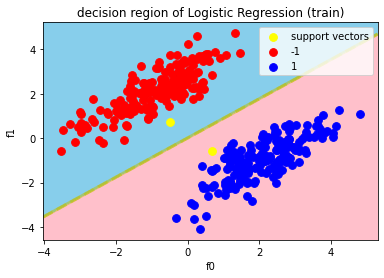

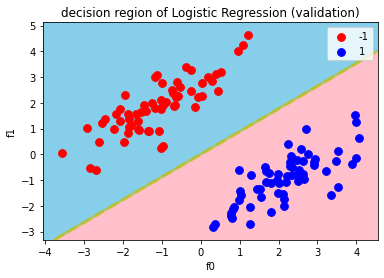

Accuracy : 1.000
Precision : 1.000
Recall : 1.000
F1 : 1.000
confusion matrix 
 [[63  0]
 [ 0 62]]



In [10]:
# sklearn
print("=== SVM Classifier (scikit-learn) ===\n")

# 学習・推論 
svm = SVC(max_iter=3000, kernel='linear')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
        
# 可視化（特徴量2つの学習モデル使用）
print('Decision Region(train/validation)')
decision_region(X_train, y_train.flatten(), svm, SV=True,
                title="decision region of Logistic Regression (train)",
                xlabel='f0', ylabel='f1', target_names=['-1', '1'])
decision_region(X_test, y_test.flatten(), svm, SV=False,
                title="decision region of Logistic Regression (validation)",
                xlabel='f0', ylabel='f1', target_names=['-1', '1'])

# 評価
print("Accuracy : {:.3f}\nPrecision : {:.3f}\nRecall : {:.3f}\nF1 : {:.3f}\nconfusion matrix \n {}\n"
          .format(*evaluate(y_test, y_pred)))

=== SVM Classifier (Scratch) ===

Decision Region(train/validation)


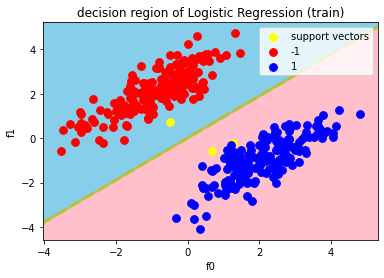

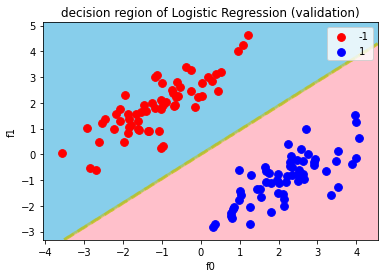

Accuracy : 1.000
Precision : 1.000
Recall : 1.000
F1 : 1.000
confusion matrix 
 [[63  0]
 [ 0 62]]



In [11]:
# Scratch
print("=== SVM Classifier (Scratch) ===\n")

# 学習・推論 
ssvm = ScratchSVMClassifier(3000, 0.001, kernel='linear', threshold=1e-5, verbose=False)
ssvm.fit(X_train, y_train, X_test, y_test)
y_pred = ssvm.predict(X_test)
        
# 可視化
print('Decision Region(train/validation)')
decision_region(X_train, y_train.flatten(), ssvm, SV=True,
                title="decision region of Logistic Regression (train)",
                xlabel='f0', ylabel='f1', target_names=['-1', '1'])
decision_region(X_test, y_test.flatten(), ssvm, SV=False,
                title="decision region of Logistic Regression (validation)",
                xlabel='f0', ylabel='f1', target_names=['-1', '1'])

# 評価
print("Accuracy : {:.3f}\nPrecision : {:.3f}\nRecall : {:.3f}\nF1 : {:.3f}\nconfusion matrix \n {}\n"
          .format(*evaluate(y_test, y_pred)))

In [12]:
# サポートベクトル数のプロット
def plot_n_SVs(n_iter, n_SVs):
    plt.plot(np.arange(n_iter), n_SVs, label='SV')
    plt.title('number of support vectors')
    plt.xlabel('iter')
    plt.ylabel('number')
    plt.legend()
    plt.show()

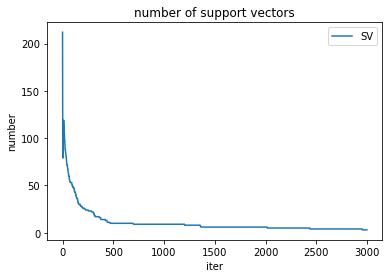

In [13]:
# 上記の学習で確認
plot_n_SVs(3000, ssvm.n_SVs)

- 同じiteration回数だと、スクラッチの方がsupport vectorの数が多い
- ただし、thresholdの設定などでも変わってくるだろう

### 【問題6】多項式カーネル関数の作成  
最初に作成した実装では線形カーネルを使用していました。多項式カーネルにも切り替えられるようにしましょう。

「線形カーネルの式」

$$
k(x_i,x_j)=x_i^Tx_j
$$

「多項式カーネルの式」

$$
k(x_i,x_j)=({\gamma}x_i^Tx_j+\theta_0)^d
$$

$\gamma$, $\theta_0$, $d$ はハイパーパラメータです。  
線形カーネルは $\gamma = 1$, $\theta_0 = 0$, $d = 1$の場合の多項式カーネルと等しいと言えます。

### ＜カーネル＞  
最後の式の $x_{i}^{T} x_j$ の部分を $k(x_i, x_j)$ という関数に置き換えます。この関数を カーネル関数 と呼びます。

$$
\sum_{i=1}^{N}\lambda_i-\frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}\lambda_i\lambda_jy_iy_jk(x_i,x_j)
$$

この式が問題1の最急降下法の式の元になります。  
カーネル関数は $x_{i}^{T} x_j$ ではない様々な計算に置き換えることができます。この部分を置き換えるだけで、元の特徴量を **高次元空間** に移動させたことと同じ結果が得られ、高い分類性能を得ることができます。これを **カーネルトリック** と呼びます。


### ＜高次元へ移す簡単な例＞  
次の図のように1次元上に2色の点があるとします。これらを直線一本を引くことで分けることは不可能です

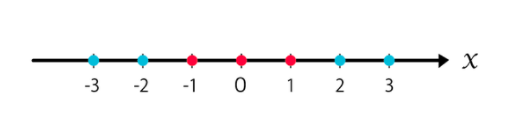

In [14]:
Image("6-2.png")

しかし、例えば以下のように変換してみると直線でも分けられそうです。  
$x^2=2.5$ あたりに線を引くことになります。

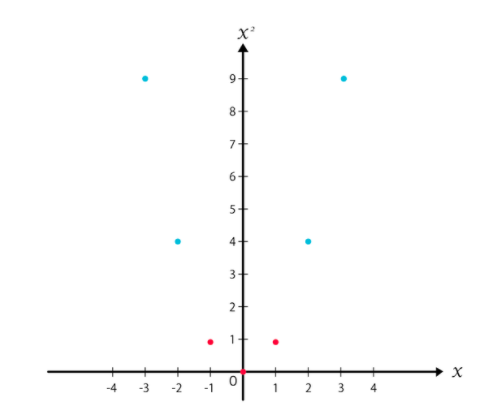

In [15]:
Image("6-3.png")

これは$x^2$を計算し、それを縦軸にプロットしたグラフです。1次元だったデータを $\phi(x)=x^2$ の関数により高次元（2次元）へと移動しました。  
こういったことをSVMはカーネルトリックにより行います。

In [16]:
# 多項式/ガウスカーネル学習用にmake_moonsデータをロード
X, y = make_moons(n_samples=500,
                  shuffle=True,
                  noise=0.1)

# ラベルを(0/1)から(-1/1)へ変更
y = np.where(y==0, 1, -1)[:, np.newaxis]
data = np.hstack([X, y])
df_m = pd.DataFrame(data, columns=['f0', 'f1', 'class'])
print('< Make Moons >')
display(df_m.head())
print('size : {}'.format(np.shape(df_m)))

< Make Moons >


,f0,f1,class
0,0.828225,0.439395,1.0
1,0.451423,0.770671,1.0
2,-0.547147,0.735167,1.0
3,0.487136,-0.468960,-1.0
4,-0.094918,1.126902,1.0


size : (500, 3)


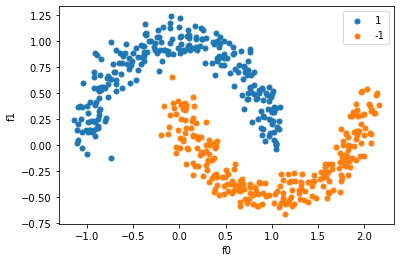

In [17]:
# 可視化
X = df_m.iloc[:, :-1].values
y = df_m.iloc[:, -1].values

a0, b0 = X[y==1,0], X[y==1,1]
a1, b1 = X[y==-1,0], X[y==-1,1]

plt.scatter(a0, b0, marker='o', s=25, label="1")
plt.scatter(a1, b1, marker='o', s=25, label="-1")
plt.legend()
plt.xlabel("f0")
plt.ylabel("f1")
plt.show()

In [18]:
# 訓練/検証データに3:1で分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y)

print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))

(375, 2)
(125, 2)
(375,)
(125,)


In [19]:
# 決定境界描画関数（SVM, 多次元用）
def decision_region(X, y, model, SV=False, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['0', '1']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, n_features)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    SV : bool
        support vectorを描画（訓練データのみ）
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['steelblue', 'darkorange']
    contourf_color = ['moccasin', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='darkgreen', linewidths=1, alpha=0.5)
    # support vectorの描画
    if SV:
        indices = list(set(np.arange(len(y))) - set(model.support_))
        X_1 = X[indices, :]
        y_1 = y[indices]
        plt.scatter(X[model.support_, 0], X[model.support_, 1], s=60, color='lime', label='support vectors', marker='o')
        for i, target in enumerate(set(y)):
            plt.scatter(X_1[y_1==target][:, 0], X_1[y_1==target][:, 1], s=60, color=scatter_color[i], label=target_names[i], marker='o')
    else:
        for i, target in enumerate(set(y)):
            plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=60, color=scatter_color[i], label=target_names[i], marker='o')        
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

=== SVM Classifier (scikit-learn) ===
< polynomial kernal(d＝3, γ＝1, θ＝2) >

Decision Region(train/validation)


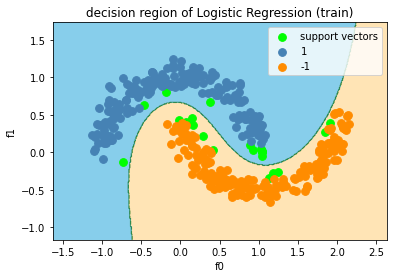

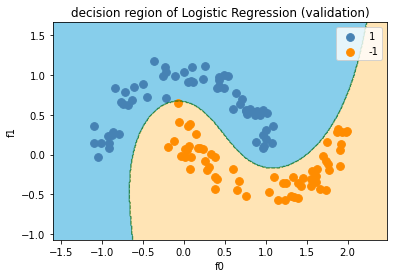

Accuracy : 1.000
Precision : 1.000
Recall : 1.000
F1 : 1.000
confusion matrix 
 [[63  0]
 [ 0 62]]



In [20]:
# sklearn
print("=== SVM Classifier (scikit-learn) ===")
print("< polynomial kernal(d＝3, γ＝1, θ＝2) >\n")

# 学習・推論 
svm_2 = SVC(max_iter=-1, kernel='poly', gamma=1, coef0=2, degree=3)
svm_2.fit(X_train, y_train)
y_pred = svm_2.predict(X_test)
        
# 可視化（特徴量2つの学習モデル使用）
print('Decision Region(train/validation)')
decision_region(X_train, y_train.flatten(), svm_2, SV=True,
                title="decision region of Logistic Regression (train)",
                xlabel='f0', ylabel='f1', target_names=['1', '-1'])
decision_region(X_test, y_test.flatten(), svm_2, SV=False,
                title="decision region of Logistic Regression (validation)",
                xlabel='f0', ylabel='f1', target_names=['1', '-1'])

# 評価
print("Accuracy : {:.3f}\nPrecision : {:.3f}\nRecall : {:.3f}\nF1 : {:.3f}\nconfusion matrix \n {}\n"
          .format(*evaluate(y_test, y_pred)))

=== SVM Classifier (Scratch) ===
< polynomial kernal(d＝3, γ＝1, θ＝2) >

Decision Region(train/validation)


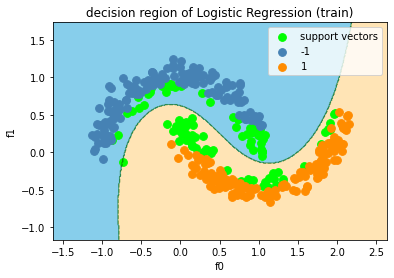

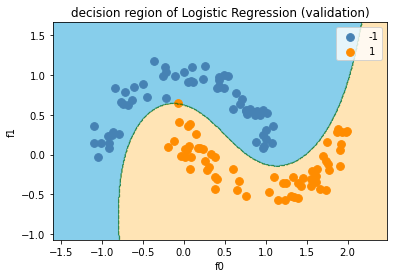

Accuracy : 0.992
Precision : 0.984
Recall : 1.000
F1 : 0.992
confusion matrix 
 [[62  1]
 [ 0 62]]



In [21]:
# Scratch
print("=== SVM Classifier (Scratch) ===")
print("< polynomial kernal(d＝3, γ＝1, θ＝2) >\n")

# 学習・推論 
ssvm_2 = ScratchSVMClassifier(3000, 0.0001, kernel='poly', d=3, theta_0=2, threshold=1e-5, verbose=False)
ssvm_2.fit(X_train, y_train)
y_pred = ssvm_2.predict(X_test)
        
# 可視化
print('Decision Region(train/validation)')
decision_region(X_train, y_train.flatten(), ssvm_2, SV=True,
                title="decision region of Logistic Regression (train)",
                xlabel='f0', ylabel='f1', target_names=['-1', '1'])
decision_region(X_test, y_test.flatten(), ssvm_2, SV=False,
                title="decision region of Logistic Regression (validation)",
                xlabel='f0', ylabel='f1', target_names=['-1', '1'])

# 評価
print("Accuracy : {:.3f}\nPrecision : {:.3f}\nRecall : {:.3f}\nF1 : {:.3f}\nconfusion matrix \n {}\n"
          .format(*evaluate(y_test, y_pred)))

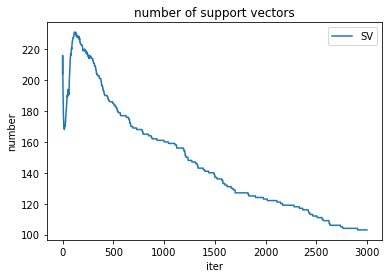

In [22]:
# support vector数の推移確認
plot_n_SVs(3000, ssvm_2.n_SVs)

- sklearnと比較しsupport vecterの数が多いが、適切に学習できているようだ

### 【おまけ】ガウスカーネル関数の作成  
多項式カーネルに加え、ガウスカーネルのスクラッチ実装を試みた。

「ガウスカーネルの式」

$$
\begin{align}
k(x_i,x_j)&=exp(-\frac{\|x_i-x_j\|^2}{2\sigma^2})\\
&=exp(-\gamma\|x_i-x_j\|^2)
\end{align}
$$

実装にあたっては、以下の関係式を利用した。

$$
\|x_i-x_j\|^2=\|x_i\|^2+\|x_j\|^2-2x_i^Tx_j
$$

=== SVM Classifier (scikit-learn) ===
< gaussian kernal (γ＝10) >

Decision Region(train/validation)


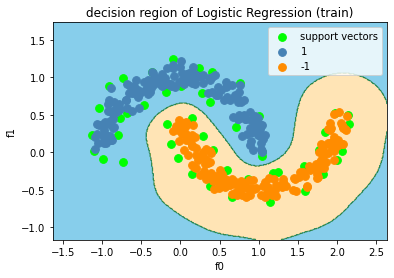

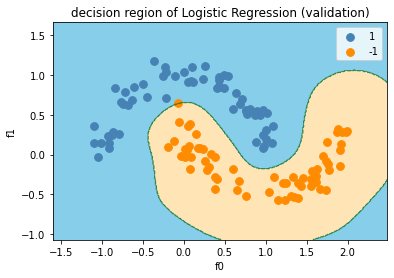

Accuracy : 0.992
Precision : 0.984
Recall : 1.000
F1 : 0.992
confusion matrix 
 [[62  1]
 [ 0 62]]



In [23]:
# sklearn
print("=== SVM Classifier (scikit-learn) ===")
print("< gaussian kernal (γ＝10) >\n")

# 学習・推論 
svm_2 = SVC(max_iter=-1, kernel='rbf', gamma=10)
svm_2.fit(X_train, y_train)
y_pred = svm_2.predict(X_test)
        
# 可視化
print('Decision Region(train/validation)')
decision_region(X_train, y_train.flatten(), svm_2, SV=True,
                title="decision region of Logistic Regression (train)",
                xlabel='f0', ylabel='f1', target_names=['1', '-1'])
decision_region(X_test, y_test.flatten(), svm_2, SV=False,
                title="decision region of Logistic Regression (validation)",
                xlabel='f0', ylabel='f1', target_names=['1', '-1'])

# 評価
print("Accuracy : {:.3f}\nPrecision : {:.3f}\nRecall : {:.3f}\nF1 : {:.3f}\nconfusion matrix \n {}\n"
          .format(*evaluate(y_test, y_pred)))

=== SVM Classifier (Scratch) ===
< gaussian kernal(γ＝1000) >

Decision Region(train/validation)


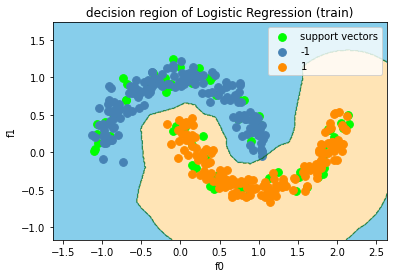

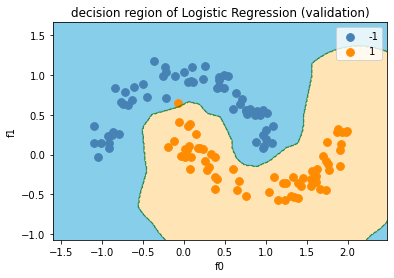

Accuracy : 0.992
Precision : 0.984
Recall : 1.000
F1 : 0.992
confusion matrix 
 [[62  1]
 [ 0 62]]



In [24]:
# Scratch
print("=== SVM Classifier (Scratch) ===")
print("< gaussian kernal(γ＝1000) >\n")

# 学習・推論 
ssvm_3 = ScratchSVMClassifier(10, 0.0001, kernel='rbf', gamma=1000, threshold=0.01, verbose=False)
ssvm_3.fit(X_train, y_train)
y_pred = ssvm_3.predict(X_test)
        
# 可視化
print('Decision Region(train/validation)')
decision_region(X_train, y_train.flatten(), ssvm_3, SV=True,
                title="decision region of Logistic Regression (train)",
                xlabel='f0', ylabel='f1', target_names=['-1', '1'])
decision_region(X_test, y_test.flatten(), ssvm_3, SV=False,
                title="decision region of Logistic Regression (validation)",
                xlabel='f0', ylabel='f1', target_names=['-1', '1'])

# 評価
print("Accuracy : {:.3f}\nPrecision : {:.3f}\nRecall : {:.3f}\nF1 : {:.3f}\nconfusion matrix \n {}\n"
          .format(*evaluate(y_test, y_pred)))

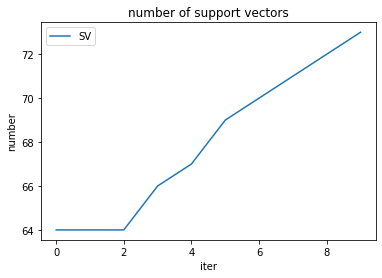

In [25]:
# support vectr数の推移確認
plot_n_SVs(10, ssvm_3.n_SVs)

- 決定境界をみるとsklearnと同じような挙動であるが、γの値は大きく変えた
- itarationすればするほど、support vectrの数は増える一方であった